In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [66]:
# Hyperparameters
batch_size = 256
learning_rate = 0.001
epochs = 20

In [67]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [68]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_dataset = list(filter(lambda x: x[1] in [1,2], mnist_dataset))
print(len(mnist_dataset))
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

KeyboardInterrupt: 

In [69]:

generator = Generator()
discriminator = Discriminator()

loss_func = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        cur_bs = real_images.shape[0]
        # Generate fake picture
        z = torch.randn(cur_bs, 100)
        fake_images = generator(z)
        assert fake_images.shape == (cur_bs, 28*28)
        assert real_images.shape == (cur_bs, 1, 28, 28)
        # Train discriminator
        optimizer_D.zero_grad()

        ons_vec = torch.ones(cur_bs, 1)
        zeros_vec = torch.zeros(cur_bs, 1)
        
        real_outputs = discriminator(real_images.view(cur_bs, -1))
        fake_outputs = discriminator(fake_images.detach().view(cur_bs, -1))

        assert real_outputs.shape == (cur_bs, 1)
        assert fake_outputs.shape == (cur_bs, 1)

        loss_real = loss_func(real_outputs, ons_vec)
        loss_fake = loss_func(fake_outputs, zeros_vec)
        loss_discriminator = loss_real + loss_fake

        loss_discriminator.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        generated_outputs = discriminator(fake_images.view(cur_bs, -1))
        loss_generator = loss_func(generated_outputs, ons_vec)

        loss_generator.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {loss_discriminator.item()}] [G loss: {loss_generator.item()}]")


[Epoch 0/20] [Batch 0/106] [D loss: 1.3684730529785156] [G loss: 0.7264608144760132]
[Epoch 0/20] [Batch 100/106] [D loss: 0.16047653555870056] [G loss: 4.306291580200195]
[Epoch 1/20] [Batch 0/106] [D loss: 0.1934034377336502] [G loss: 4.373029708862305]
[Epoch 1/20] [Batch 100/106] [D loss: 0.3697589933872223] [G loss: 2.1530890464782715]
[Epoch 2/20] [Batch 0/106] [D loss: 0.32254138588905334] [G loss: 1.774085521697998]
[Epoch 2/20] [Batch 100/106] [D loss: 0.5663562417030334] [G loss: 1.8599668741226196]
[Epoch 3/20] [Batch 0/106] [D loss: 0.7050473690032959] [G loss: 1.7461076974868774]
[Epoch 3/20] [Batch 100/106] [D loss: 0.14273865520954132] [G loss: 4.655003547668457]
[Epoch 4/20] [Batch 0/106] [D loss: 0.1465809941291809] [G loss: 5.049220561981201]
[Epoch 4/20] [Batch 100/106] [D loss: 0.08027864992618561] [G loss: 5.295048236846924]
[Epoch 5/20] [Batch 0/106] [D loss: 0.231972336769104] [G loss: 4.557861328125]
[Epoch 5/20] [Batch 100/106] [D loss: 0.23110872507095337] [G 

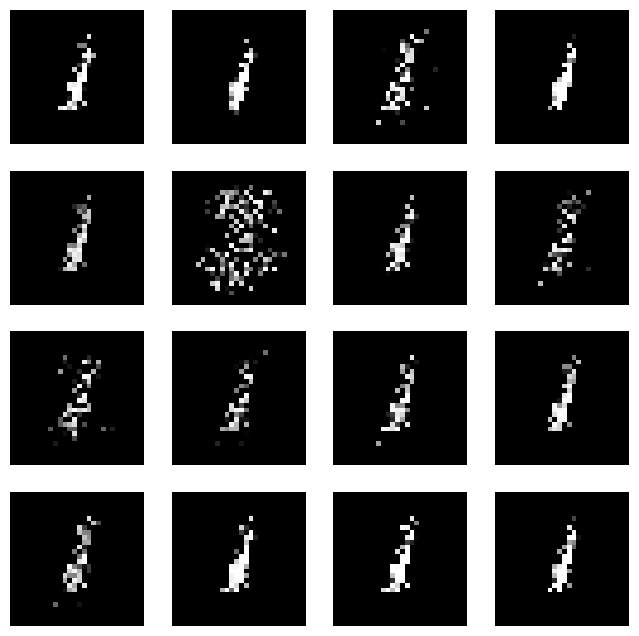

In [70]:
# Generate and save some sample images
with torch.no_grad():
    z = torch.randn(16, 100)
    generated_samples = generator(z)
    generated_samples = generated_samples.view(-1, 1, 28, 28).clamp(0, 1).numpy()

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for ax, img in zip(axes.flatten(), generated_samples):
        ax.imshow(img[0], cmap='gray')
        ax.axis('off')
    plt.show()